In [40]:
import pandas as pd
test = pd.read_csv("test_V2.csv")
train = pd.read_csv("train_V2.csv")

In [41]:
import gc
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(42)

Feature descriptions (From Kaggle)

DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.


killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints 
should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance - Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints 
should be treated as a “None”.

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB



This shows a description of the data set. Most of the data are ints and floats, but four of the columns are objects. This will need to be dealt with later.


In [43]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [44]:
train.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0,0,0.000,0,0,1019.0,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0,0,0.000,0,0,81.7,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0,0,2.184,0,0,788.7,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0,0,0.000,0,0,2748.0,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,...,0,1369.0,0,0.000,0,0,1244.0,5,0,0.5464


In [45]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [46]:
print('Shape of training set: ', train.shape)

Shape of training set:  (4446966, 29)


In [47]:
train.drop(2744604, inplace=True)

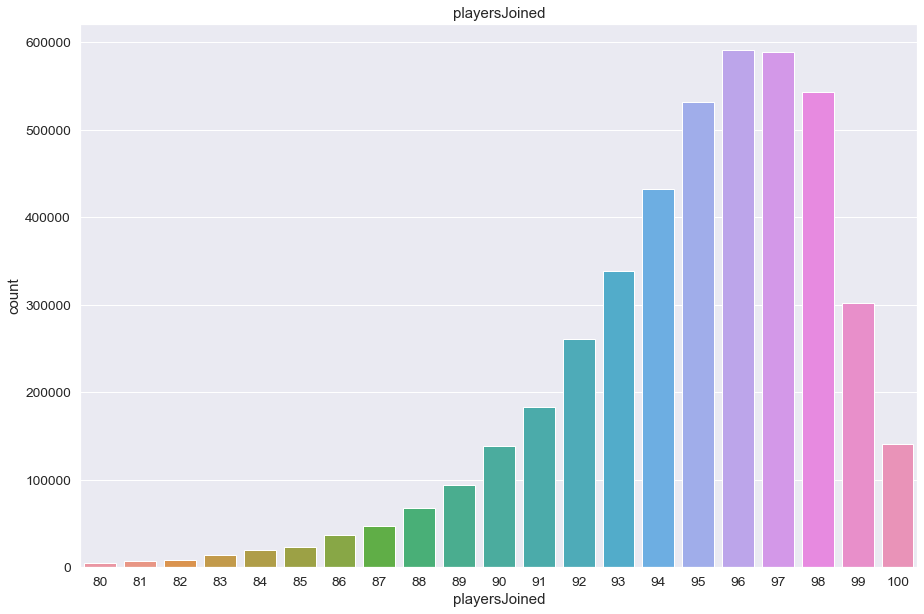

In [48]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined']>=80]['playersJoined'])
plt.title('playersJoined')
plt.show()


Using seaborn library, I created a bar graph of the number of players joined. This helps give us context in regards to the number of kills a player gets in a match. Most matches had between 90-100 players, so they were almost full games.


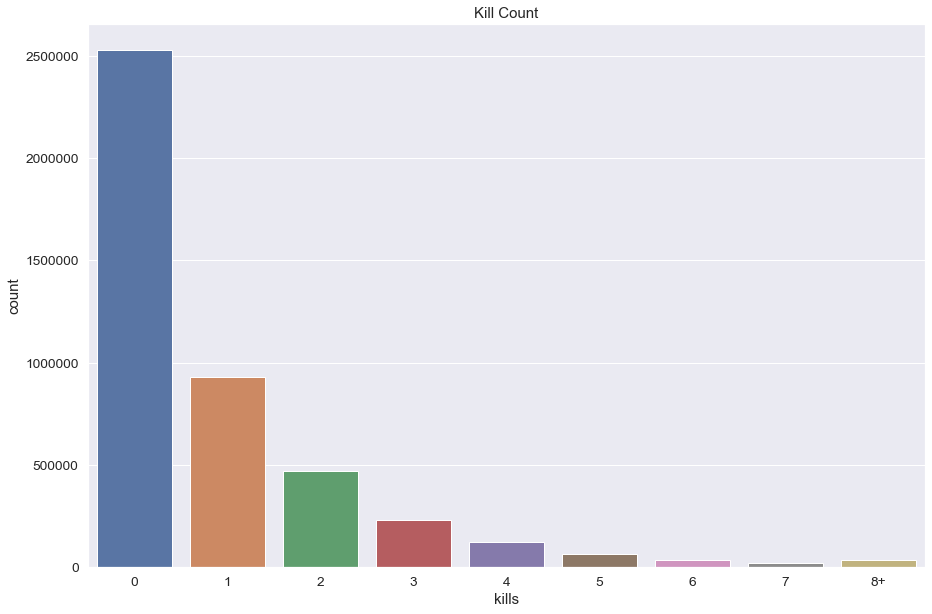

In [49]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count", fontsize = 15)
plt.show()


This bar graph of the number of kills players were getting in a match. It shows most players died without getting kills. It was very rare for a player to get 4+ kills in a single game. Maybe # of kills in a match correlates highly with a higher final placement?

The plot below shows the correlation between kills and player final placement.



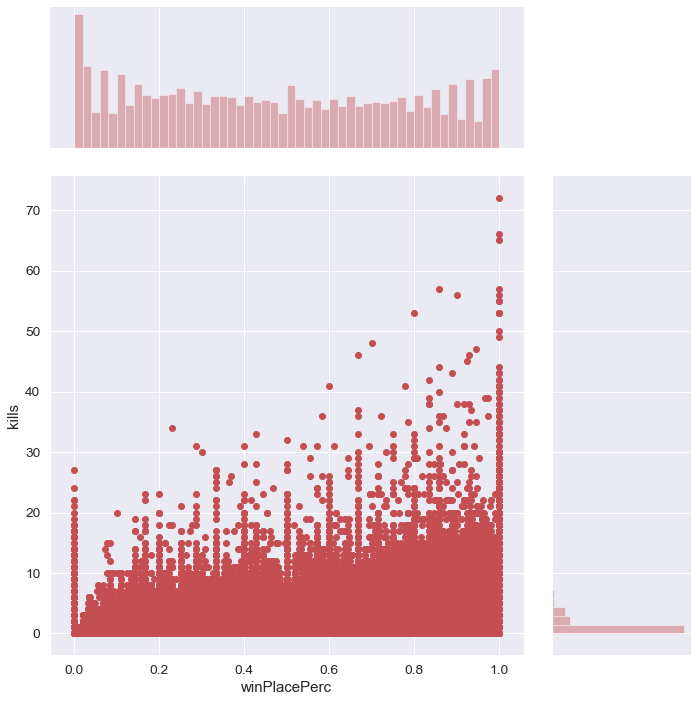

In [50]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, height=10, ratio=3, color="r")
plt.show()

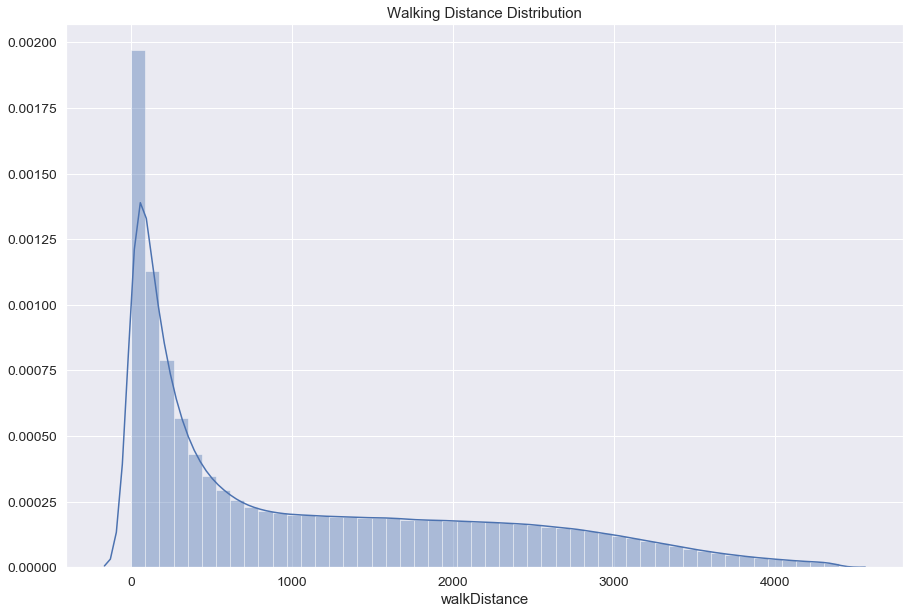

In [51]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize = 15)
sns.distplot(data['walkDistance'])
plt.show()


Walking distance is an important statistic because the further a player walked, the longer they survived. The longer a player survived, the higher their final placement will be. This graph also shows when players were being eliminated in a match. The large bump at the begining of the graph indicates that most players die early on before they have a chance to move around the map.

The plot below shows a strong correlation between walking distance and final placement. This is likely due to the game mechanic that keeps players moving around the map. So to make it to the end a player must walk large distances. 


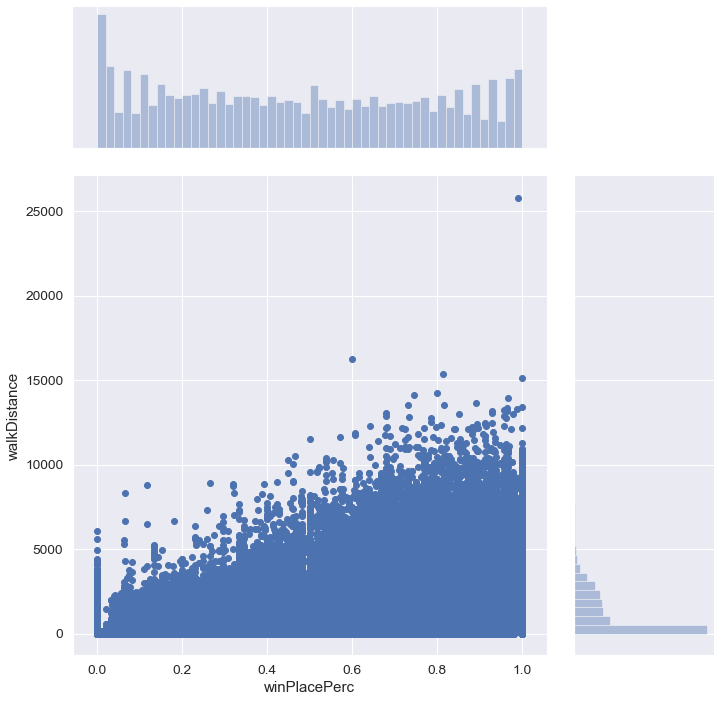

In [52]:
sns.jointplot(x="winPlacePerc", y="walkDistance", data = train, height=10, ratio=3, color="b")
plt.show()

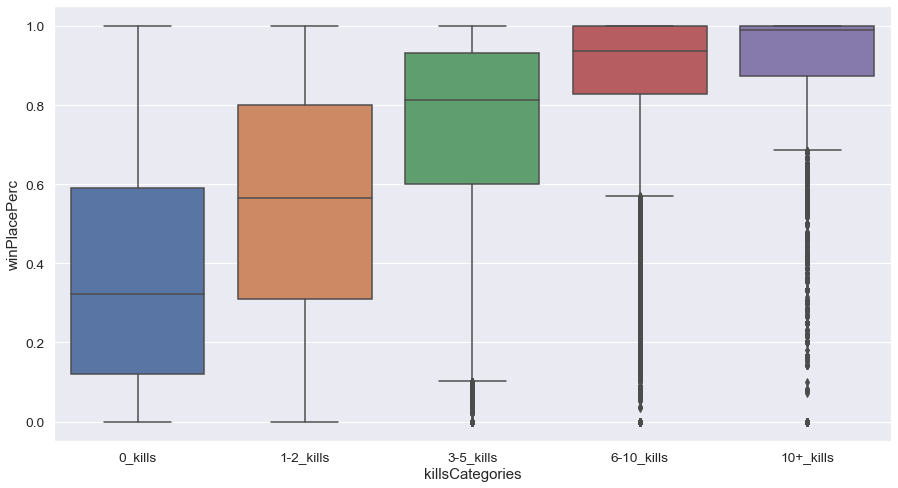

In [53]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()


This box plot is another look at the correlation between kills and a players placement. 


In [54]:
def kills_players_joined(df):
    df['kills_players_joined'] = df['kills'] / df['playersJoined']
    df['kills_players_joined'].fillna(0, inplace=True)
    return df

kills_players_joined(train)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,kills_players_joined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.000,0,0,244.80,1,1466,0.4444,96,0.000000
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,11.040,0,0,1434.00,5,0,0.6400,91,0.000000
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.000,0,0,161.80,2,0,0.7755,98,0.000000
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.000,0,0,202.70,3,0,0.1667,91,0.000000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.000,0,0,49.75,2,0,0.1875,97,0.010309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,0.000,0,0,1019.00,3,1507,0.1786,94,0.000000
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.000,0,0,81.70,6,0,0.2935,93,0.000000
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,2.184,0,0,788.70,4,0,0.4815,98,0.000000
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,0,0.000,0,0,2748.00,8,0,0.8000,94,0.021277



I thought that it would be important to look at (kills / number of players joined). This is because if a player gets 5 kills in a lobby with 90 players, that is more impressive than getting 5 kills in a lobby with 100 players. So I created the statistic and then ploted the correlation.


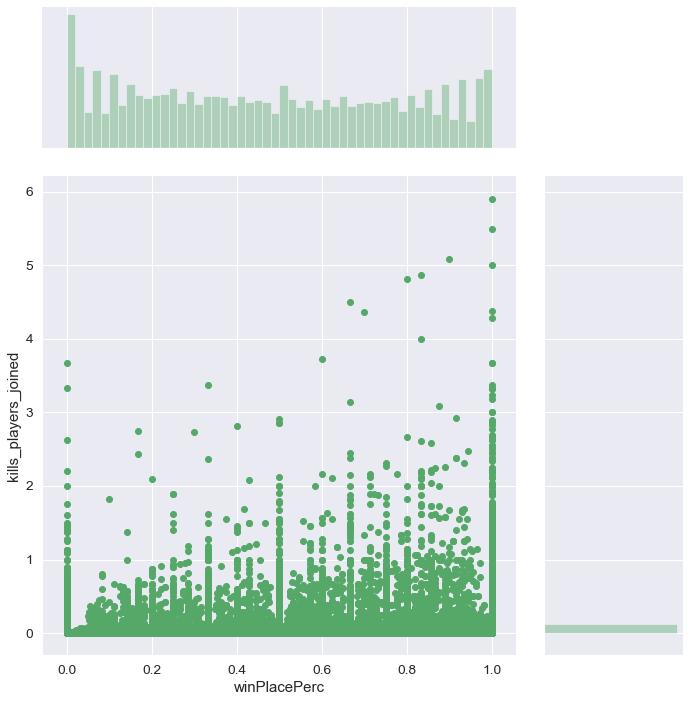

In [55]:
sns.jointplot(x="winPlacePerc", y="kills_players_joined", data=train, height=10, ratio=3, color="g")
plt.show()

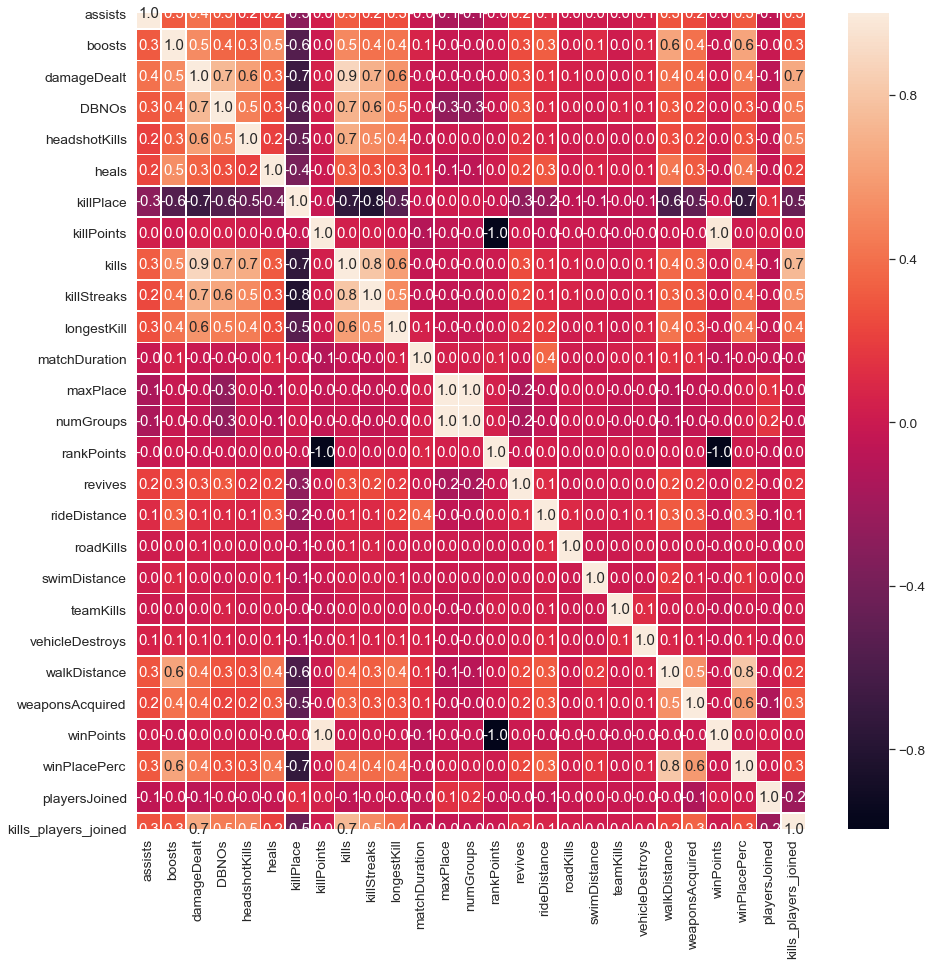

In [56]:
f,ax = plt.subplots(figsize=(15,15))
sns.heatmap(train.corr(),annot=True, linewidths=.5, fmt='.1f',ax=ax)
plt.show()



These two heatmaps show the correlation between the individual statistics and the players final placement. The top heat map shows all of the stats and the bottom just shows the 4 most correlating stats.



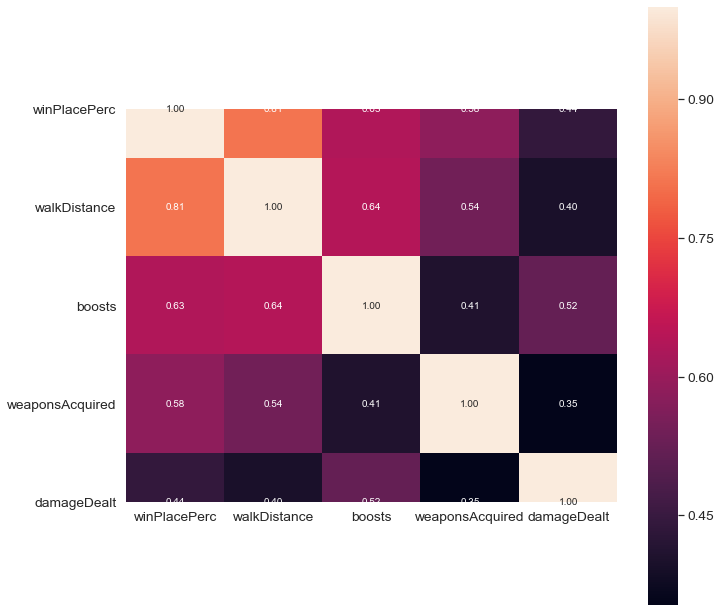

In [57]:
k = 5
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [58]:
train.shape

(4446965, 31)

In [59]:
train.drop(columns=['groupId', 'matchId'], inplace=True)
train.drop(columns = ['Id'], inplace=True)

##DROP THE IDS BECAUSE THEY DONT AFFECT THE RESULTS AND BECAUSE THEY ARE OBJECTS

In [60]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

le = LabelEncoder() 
  
train['matchType']= le.fit_transform(train['matchType']) 
print(train['matchType'])

##USING LABEL ENCODING, I CONVERT THE MATCH TYPE TO AN INT. THIS IS DONE BECAUSE THE RANDOM FOREST MODEL WILL NOT TAKE OBJECTS



0          15
1          15
2           2
3          15
4          13
           ..
4446961    15
4446962    12
4446963    15
4446964    15
4446965    13
Name: matchType, Length: 4446965, dtype: int32


In [61]:
sample = 500000
df_sample = train.sample(sample)

In [62]:
df = df_sample.drop(columns = ['winPlacePerc'])
y = df_sample['winPlacePerc'] 

def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

##SPLIT THE DATA SET FOR TRAINING

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
m1 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)

##FIT THE RANDOM FOREST MODEL WITH THE TRAINING DATA
##USED 50 TREES BECAUSE IT WAS A GOOD BALANCE OF SPEED AND ACCURACY

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [65]:
test.drop(columns=['groupId', 'matchId'], inplace=True)
le = LabelEncoder()  
test['matchType']= le.fit_transform(test['matchType']) 
test.drop(columns = ['Id'], inplace=True)
sample = 500000
df_sample = test.sample(sample)

In [66]:
X_test, X_tvalid = split_vals(df, n_trn)
y_test, y_tvalid = split_vals(y, n_trn)
m1.score(X_test,y_test)

##THE SCORE OF OUR MODEL IS .967

0.9678290515999016

In [67]:
X_test.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,playersJoined,kills_players_joined
2382382,0,0,0.000,0,0,0,88,0,0,0,...,0.0,0,0.0,0,0,39.68,1,0,94,0.000000
2888096,0,0,293.300,2,0,0,19,1157,2,1,...,0.0,0,0.0,0,0,179.00,7,1509,95,0.021053
1272655,0,0,0.000,0,0,0,47,1346,0,0,...,849.2,0,0.0,0,0,2839.00,4,1495,97,0.000000
3529396,0,1,71.410,1,0,1,30,0,1,1,...,0.0,0,0.0,0,0,770.70,3,0,93,0.010753
3617300,1,0,2.189,0,0,0,53,1019,0,0,...,911.0,0,0.0,0,0,287.50,2,1475,86,0.000000


In [68]:
y_test.head()

2382382    0.0652
2888096    0.0385
1272655    0.8571
3529396    0.4615
3617300    0.3778
Name: winPlacePerc, dtype: float64

In [75]:
m1.predict(X_test)

array([0.05454494, 0.18985338, 0.83167318, ..., 0.76363123, 0.58157902,
       0.46982461])